<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Practical 6 - Understanding Recurrent Neural Networks</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

keras:  2.2.4-tf


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Objectives
After completing this practical exercise, students should be able to:
1. [Understand how to use the simple recurrent layer](#simple)
2. [Understand how to use LSTM layers to build RNN ](#lstm)
3. [Exercise: Use GRU layers to build RNN](#exc)

## 1. Understand the simple recurrent layer in Keras <a id='simple' />

We will start by using a simple RNN layer in Keras: the `SimpleRNN` layer:


In [3]:
from tensorflow.keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences, like all other Keras layers. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`.`SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. Let's take a look at an example:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
#Embedding is a popular method to process text data.
#We will cover more on word embedding in Practical 7.

model = Sequential()
model.add(Embedding(10000, 16)) #receive word embedding as input
model.add(SimpleRNN(32))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1568      
Total params: 161,568
Trainable params: 161,568
Non-trainable params: 0
_________________________________________________________________


In [5]:
model = Sequential()
model.add(Embedding(10000, 16))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          1568      
Total params: 161,568
Trainable params: 161,568
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [6]:
model = Sequential()
model.add(Embedding(10000, 16))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          1568      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
Total params: 165,728
Trainable params: 165,728
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [7]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 200  # cut texts after this number of words (among top max_features most common words)
batch_size = 128

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [8]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 16, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 16)           160000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 200, 32)           1568      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 163,681
Trainable params: 163,681
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.6207 - acc: 0.6348 -

Let's display the training and validation loss and accuracy:

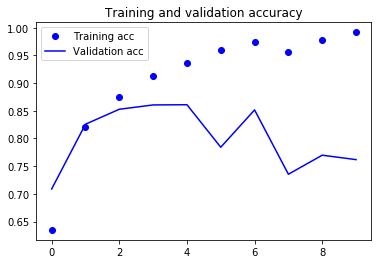

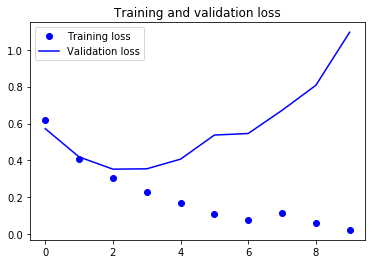

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in week 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only around 80% validation accuracy). Part of the problem is that our inputs only consider 200 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some more advanced layers.

## 2. Understand the LSTM layer in Keras <a id='lstm' />

We will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [10]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 16, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 200, 32)           6272      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 174,625
Trainable params: 174,625
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 129s 6ms/sample - loss: 0.5258 - acc: 0.7243 - val_loss: 0.4076 - val_acc: 0.8176
Epoch 2/10
20000/20000 [==============================] - 120s 6ms/sample - loss: 0.3187 - acc: 0.8716 - val_loss: 0.3752 - val_acc: 0.8398
Epoch 3/10
20000/20000 [==============================] - 119s 6ms/sample - loss: 0.2474 - acc: 0.9053 - val_loss: 0.4478 - val_acc: 0.8040
Epoch 4/10
20000/20000 [==============================] - 117s 6ms/sample - loss: 0.2120 - acc: 0.9210 - val_loss: 0.3331 - val_acc: 0.8714
Epoch 5/10
20000/20000 [==============================] - 130s 6ms/sample - loss: 0.1849 - acc: 0.9316 - val_loss: 0.3096 - val_acc: 0.8618
Epoch 6/10
20000/20000 [==============================] - 124s 6ms/sample - loss: 0.1624 - acc: 0.9413 - val_loss: 0.3196 - val_acc: 0.8798
Epoch 7/10
20000/20000 [==============================] - 950s 48ms/sample - loss: 0.1486 - acc: 0.9457 - val_l

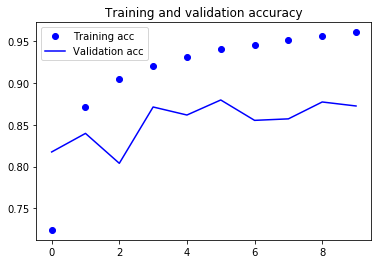

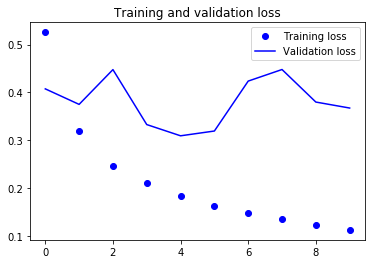

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time you achieve around 85% validation accuracy, much better than the `SimpleRNN` network because LSTM suffers much less from the vanishing-gradient problem (i.e. perform better on long sequences inputs). 

## 3. Exercise <a id='exc'/>
We would like you to further improve the above model performance by tuning different parametars. Below are a few suggestions you can try but feel free to adjust other parametars if required.

1) Stack more recurrent layers on top of each other or remove recurrent layers. (Remember to set `return_sequences=True` for all the recurrent layers except the last one).

2) Add in dropout regularization. In RNN, there are two types of dropout regularization:
* dropout: the normal dropout which randomly drops the inputs of the layer;
* recurrent_dropout: special dropout for recurrent layer only, where the dropout happens within reccurnt unit between different Sates (t-1, t, t+1)


3) Use a different type of recurrent layer, e.g. **GRU(Gated Recurrent Units)**. Don't know what is GRU, please check out this [**website**](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21).

Provide your codes & observations in the below code boxes & markdown boxes respectively.

In [20]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 200  # cut texts after this number of words (among top max_features most common words)
batch_size = 128

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [21]:
# Task 1: Build the Model
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 16, input_length=maxlen)) 
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 16)           160000    
_________________________________________________________________
gru_28 (GRU)                 (None, 200, 32)           4704      
_________________________________________________________________
gru_29 (GRU)                 (None, 200, 32)           6240      
_________________________________________________________________
gru_30 (GRU)                 (None, 200, 32)           6240      
_________________________________________________________________
gru_31 (GRU)                 (None, 200, 32)           6240      
_________________________________________________________________
gru_32 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

In [22]:
# Task 2: Compile and Fit the Model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 101s 5ms/sample - loss: 0.5916 - acc: 0.6522 - val_loss: 0.3868 - val_acc: 0.8282
Epoch 2/10
20000/20000 [==============================] - 106s 5ms/sample - loss: 0.3551 - acc: 0.8541 - val_loss: 0.4472 - val_acc: 0.8154
Epoch 3/10
20000/20000 [==============================] - 111s 6ms/sample - loss: 0.2759 - acc: 0.8922 - val_loss: 0.3163 - val_acc: 0.8668
Epoch 4/10
20000/20000 [==============================] - 107s 5ms/sample - loss: 0.2352 - acc: 0.9136 - val_loss: 0.3162 - val_acc: 0.8672
Epoch 5/10
20000/20000 [==============================] - 105s 5ms/sample - loss: 0.2023 - acc: 0.9276 - val_loss: 0.3270 - val_acc: 0.8724
Epoch 6/10
20000/20000 [==============================] - 104s 5ms/sample - loss: 0.1863 - acc: 0.9332 - val_loss: 0.3629 - val_acc: 0.8544
Epoch 7/10
20000/20000 [==============================] - 104s 5ms/sample - loss: 0.1684 - acc: 0.9416 - val_lo

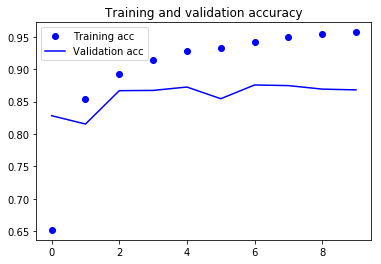

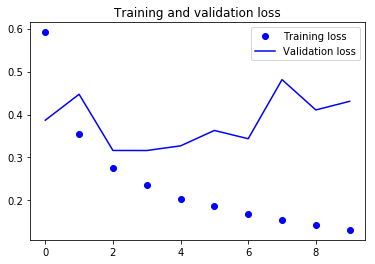

In [25]:
# Task 3: Plot the acc & loss curves for both train & validation datasets
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Task 4: Comments on the model performance
#Validation accuracy of around 85%
#Training accuracy and loss is smoother than validation accuracy and loss